#### Import needed dependecies

In [1]:
import os
import numpy as np
import pandas as pd
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix

In [2]:
# runs all cells in data_preprocessing.ipynb
%run data_preprocessing.ipynb

[nltk_data] Downloading package punkt to
[nltk_data]     /home/danielmasamba/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/danielmasamba/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/danielmasamba/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Transformed X_train shape: (620, 728)
Transformed X_test  shape: (267, 728)


## Train and evaluate without cross-validation

#### Simple train/validation split (no CV)

In [3]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_transformed, 
    y_train.values.ravel(),
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

#### Fit & evaluate Decision tree and KNN classifiers

In [4]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_tr, y_tr)
y_val_pred = dt.predict(X_val)
print("Decision Tree\n", classification_report(y_val, y_val_pred))

Decision Tree
               precision    recall  f1-score   support

           0       0.69      0.69      0.69        42
           1       0.84      0.84      0.84        82

    accuracy                           0.79       124
   macro avg       0.77      0.77      0.77       124
weighted avg       0.79      0.79      0.79       124



In [5]:
# KNN
knn = KNeighborsClassifier()
knn.fit(X_tr, y_tr)
print("KNN\n", classification_report(y_val, knn.predict(X_val)))

KNN
               precision    recall  f1-score   support

           0       0.73      0.45      0.56        42
           1       0.77      0.91      0.83        82

    accuracy                           0.76       124
   macro avg       0.75      0.68      0.70       124
weighted avg       0.75      0.76      0.74       124



#### PyTorch MLP on a fixed split

In [6]:
# wrap into DataLoader
train_ds = TensorDataset(torch.from_numpy(X_tr).float(), torch.from_numpy(y_tr).float())
val_ds   = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)

In [7]:
# simple MLP
class MLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim,128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128,64),    nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64,1)
        )
    def forward(self,x): return self.net(x).squeeze(1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(X_tr.shape[1]).to(device)
opt   = torch.optim.Adam(model.parameters(), lr=1e-3)
crit  = nn.BCEWithLogitsLoss()

# training loop
for epoch in range(20):
    model.train()
    for xb,yb in train_loader:
        xb,yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        loss = crit(model(xb), yb)
        loss.backward(); opt.step()

# evaluate

model.eval()
preds, trues = [], []
with torch.no_grad():
    for xb,yb in val_loader:
        xb = xb.to(device)
        probs = torch.sigmoid(model(xb)).cpu().numpy()
        preds.extend((probs>0.5).astype(int))
        trues.extend(yb.numpy().astype(int))

print("MLP\n", classification_report(trues, preds))
print("MLP F1:", f1_score(trues, preds))


MLP
               precision    recall  f1-score   support

           0       0.95      0.93      0.94        42
           1       0.96      0.98      0.97        82

    accuracy                           0.96       124
   macro avg       0.96      0.95      0.95       124
weighted avg       0.96      0.96      0.96       124

MLP F1: 0.9696969696969697


## Train and evaluate with cross-validation

#### Flatten labels

In [8]:
y = y_train.values.ravel()

#### Decision Tree and KNN via scikit-learn CV

In [9]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scorer = make_scorer(f1_score)

models = [
    # Decision Tree
    ("Decision Tree",
     DecisionTreeClassifier(
         max_depth=5,
         min_samples_split=2,
         min_samples_leaf=1,
         random_state=42
     )
    ),
    # KNN
    ("KNN",
     KNeighborsClassifier(
         n_neighbors=5,
        weights='uniform'
     )
    )
]

cv_results = {}

# run cross_validate for each model
for name, clf in models:
    pipe = Pipeline([
        ("preproc", preprocessor),
        ("clf",      clf)
    ])
    results = cross_validate(
        pipe,
        X_train,
        y,
        cv=cv,
        scoring=f1_scorer,
        return_train_score=True,
        n_jobs=-1
    )
    cv_results[name] = results

    # print per‐fold F1
    train_f1 = results['train_score']
    val_f1   = results['test_score']
    print(f"\n{name} F1 scores by fold:")
    for fold, (tr, va) in enumerate(zip(train_f1, val_f1), start=1):
        print(f"  Fold {fold:>1d}: train F1 = {tr:.3f},  val F1 = {va:.3f}")


Decision Tree F1 scores by fold:
  Fold 1: train F1 = 0.947,  val F1 = 0.867
  Fold 2: train F1 = 0.943,  val F1 = 0.847
  Fold 3: train F1 = 0.940,  val F1 = 0.889
  Fold 4: train F1 = 0.924,  val F1 = 0.867
  Fold 5: train F1 = 0.930,  val F1 = 0.895

KNN F1 scores by fold:
  Fold 1: train F1 = 0.908,  val F1 = 0.862
  Fold 2: train F1 = 0.916,  val F1 = 0.872
  Fold 3: train F1 = 0.913,  val F1 = 0.856
  Fold 4: train F1 = 0.910,  val F1 = 0.869
  Fold 5: train F1 = 0.898,  val F1 = 0.859


In [10]:
# build DataFrame of results
rows = []
for model_name, res in cv_results.items():
    for fold_idx, (train_score, test_score, fit_time, score_time) in enumerate(
        zip(res['train_score'], res['test_score'], res['fit_time'], res['score_time']),
        start=1
    ):
        rows.append({
            'model'       : model_name,
            'fold'        : fold_idx,
            'train_f1'    : train_score,
            'val_f1'      : test_score,
            'fit_seconds' : fit_time,
            'score_seconds': score_time
        })

df_cv = pd.DataFrame(rows)

#### PyTorch MLP with 5-fold CV

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}\n")

# First, transform the entire feature matrix once:
X_all = preprocessor.fit_transform(X_train, y)

# Hyperparameters
EPOCHS      = 20
BATCH_SIZE  = 32
LR          = 1e-3
INPUT_DIM   = X_all.shape[1]


Using device: cuda



In [23]:
# Define a simple MLP for binary classification
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)            # single logit
        )
    def forward(self, x):
        return self.net(x).squeeze(1)  # (batch,)

In [19]:
import os
import matplotlib.pyplot as plt

def train_and_eval(train_idx, val_idx, fold=None):
    # Split data
    X_tr = torch.from_numpy(X_all[train_idx]).float()
    y_tr = torch.from_numpy(y[train_idx]).float()
    X_va = torch.from_numpy(X_all[val_idx]).float()
    y_va = torch.from_numpy(y[val_idx]).float()

    # DataLoaders
    tr_loader = DataLoader(TensorDataset(X_tr, y_tr),
                           batch_size=BATCH_SIZE, shuffle=True)
    va_loader = DataLoader(TensorDataset(X_va, y_va),
                           batch_size=BATCH_SIZE, shuffle=False)

    # Model, loss, optimizer
    model     = MLP(INPUT_DIM).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    train_losses, val_losses = [], []

    # Training loop
    for epoch in range(1, EPOCHS+1):
        model.train()
        running_train_loss = 0.0
        for xb, yb in tr_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss   = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * xb.size(0)
        train_losses.append(running_train_loss / len(tr_loader.dataset))

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for xb, yb in va_loader:
                xb, yb = xb.to(device), yb.to(device)
                loss_val = criterion(model(xb), yb)
                running_val_loss += loss_val.item() * xb.size(0)
        val_losses.append(running_val_loss / len(va_loader.dataset))

    # Plot learning curves
    plt.figure(figsize=(6,4))
    plt.plot(range(1, EPOCHS+1), train_losses, label='Train Loss')
    plt.plot(range(1, EPOCHS+1), val_losses,   label='Val   Loss')
    plt.xlabel('Epoch')
    plt.ylabel('BCEWithLogitsLoss')
    plt.title(f'MLP Learning Curves' + (f' — Fold {fold}' if fold is not None else ''))
    plt.legend()

    # Ensure directory exists and save
    os.makedirs('plots', exist_ok=True)
    fname = f'plots/mlp_learning_curve'
    if fold is not None:
        fname += f'_fold{fold}'
    fname += '.png'
    plt.savefig(fname, bbox_inches='tight', dpi=300)

    plt.show()
    
    # Final F1 on validation fold
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in va_loader:
            xb = xb.to(device)
            probs = torch.sigmoid(model(xb)).cpu().numpy()
            preds.extend((probs > 0.5).astype(int))
            trues.extend(yb.numpy().astype(int))

    return f1_score(trues, preds)


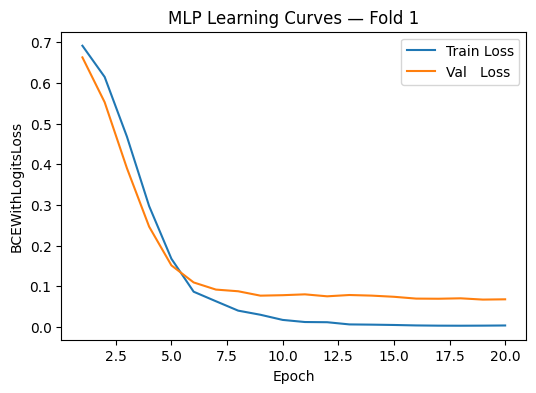

MLP Fold 1 →  F1 = 0.982


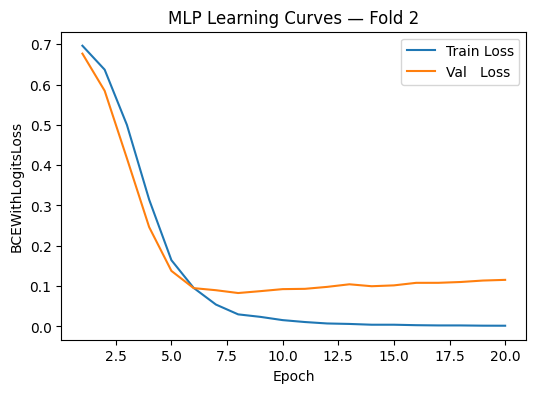

MLP Fold 2 →  F1 = 0.981


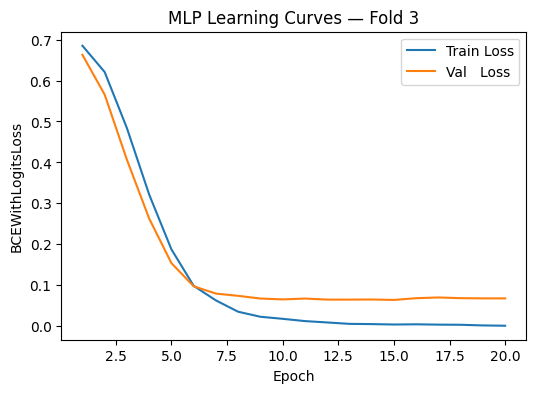

MLP Fold 3 →  F1 = 0.982


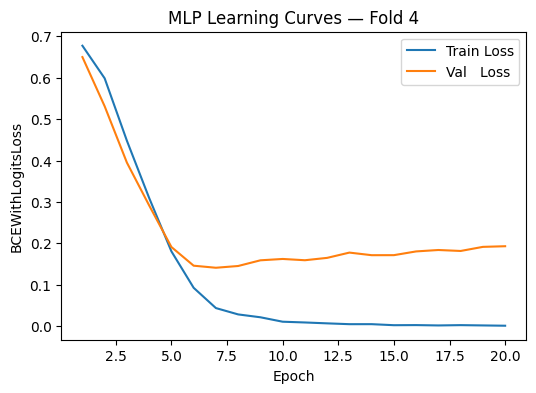

MLP Fold 4 →  F1 = 0.958


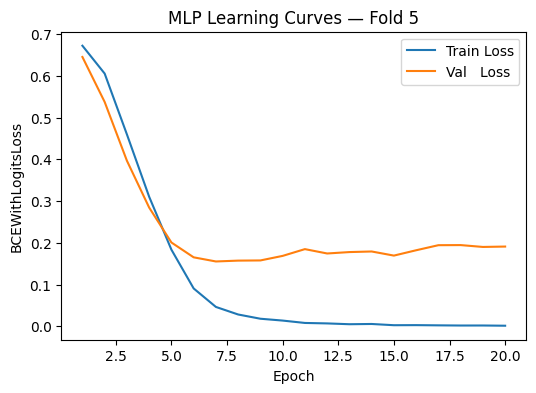

MLP Fold 5 →  F1 = 0.976

MLP  → mean F1 = 0.976,  std = 0.009


In [24]:
# Run 5-fold CV
mlp_scores = []
for fold, (tr_idx, va_idx) in enumerate(cv.split(X_all, y), start=1):
    f1 = train_and_eval(tr_idx, va_idx, fold=fold)
    mlp_scores.append(f1)
    print(f"MLP Fold {fold} →  F1 = {f1:.3f}")

print(f"\nMLP  → mean F1 = {np.mean(mlp_scores):.3f},  std = {np.std(mlp_scores):.3f}")

#### Plot bar chart for Decision Tree, KNN, and MLP

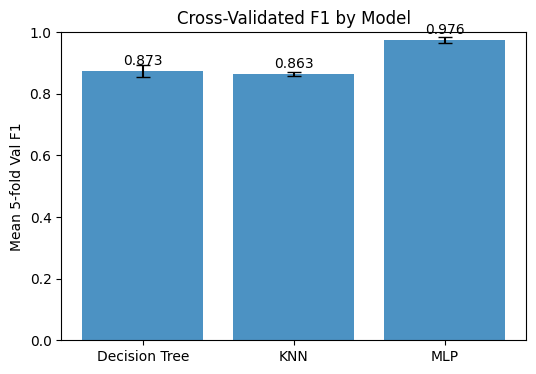

In [25]:
# Create a small DataFrame for the MLP
df_mlp = pd.DataFrame({
    'model': ['MLP'] * len(mlp_scores),
    'fold' : list(range(1, len(mlp_scores) + 1)),
    'val_f1': mlp_scores
})

# Combine with your existing DT/KNN results
# We only need model & val_f1 for the bar chart:
df_all = pd.concat([
    df_cv[['model','fold','val_f1']],
    df_mlp
], ignore_index=True)

# Compute means and stds over val_f1 by model
grouped = df_all.groupby('model')['val_f1']
means = grouped.mean()
stds  = grouped.std()

# Plot bar chart with error bars
plt.figure(figsize=(6,4))
bars = plt.bar(
    means.index,
    means.values,
    yerr=stds.values,
    capsize=5,
    alpha=0.8
)
plt.ylim(0, 1)
plt.ylabel("Mean 5-fold Val F1")
plt.title("Cross-Validated F1 by Model")

# Annotate each bar with its mean value
for bar, m in zip(bars, means.values):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        m + 0.01,
        f"{m:.3f}",
        ha='center',
        va='bottom'
    )

# Save the figure
os.makedirs('plots', exist_ok=True)
plt.savefig('plots/cv_f1_by_model_all.png', bbox_inches='tight', dpi=300)

# Display it
plt.show()


#### Plot confusion matrices for Decision Tree, KNN, and MLP

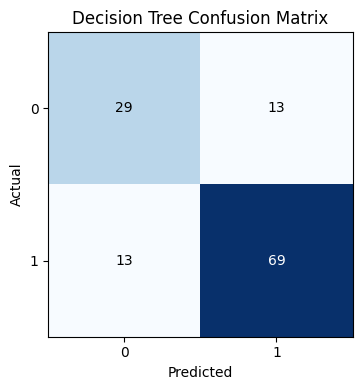

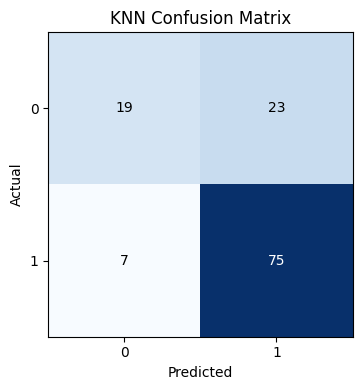

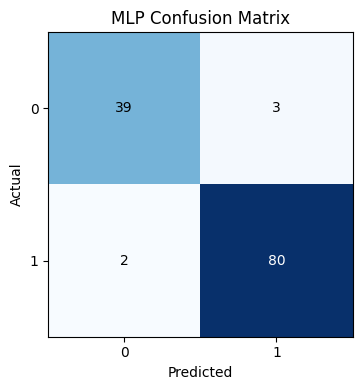

In [28]:
# ensure output directory
os.makedirs('plots', exist_ok=True)

def plot_cm(cm, model_name):
    plt.figure(figsize=(4,4))
    im = plt.imshow(cm, cmap='Blues', interpolation='nearest')
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # set proper ticks and labels
    classes = ['0','1']
    plt.xticks(np.arange(len(classes)), classes)
    plt.yticks(np.arange(len(classes)), classes)

    # annotate with contrasting text color
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if cm[i, j] > thresh else "black"
            plt.text(j, i, f"{cm[i, j]:d}",
                     ha='center', va='center',
                     color=color)

    plt.tight_layout()
    os.makedirs('plots', exist_ok=True)
    plt.savefig(f"plots/{model_name.lower().replace(' ','_')}_cm.png",
                dpi=300, bbox_inches='tight')
    plt.show()

# ——— Decision Tree ———
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_tr, y_tr)
y_pred = dt.predict(X_val)
plot_cm(confusion_matrix(y_val, y_pred), "Decision Tree")

# ——— KNN ———
knn = KNeighborsClassifier()
knn.fit(X_tr, y_tr)
y_pred = knn.predict(X_val)
plot_cm(confusion_matrix(y_val, y_pred), "KNN")

# ——— MLP ———
cm_mlp = confusion_matrix(trues, preds)
plot_cm(cm_mlp, "MLP")
